# Lab 3: Pytorch Operators and Optimizers

## Assignment: Fashion MNIST Classification

In Lab3, we will use the Fashion MNIST dataset (see video recording for explanation of Fashion MNIST dataset). Similar to previous Lab2, you should design a fully-connected network as well as the pytorch based training/validation/testing process on the classification task. But differently, we will dive into the optimizers, operations or modules that we have learned in the lectures, and to see how they can benefit the capacity of your model.



1. Try different optimizers including RMSProp, Adam and SGD(You can find the corresponding functions in the torch.optim library). Log your training loss and test accuracy. Comparing these optimizers, how do they work? Which one is the best for this task and try to explain it.

2. Analyze the overfitting/underfitting situation of your model. Try to use regularization like L2/L1, Dropout layers, etc. to improve your performance. How does your regularization work? And how do you balance your regularization and the loss optimization?

3. Try different initialization ways like random normal, Xavier and He (Kaiming) etc. How can these initialization affect your training process and performance? 

4. Try normalization like batch normalization or layer normalization, whether these normalization methods can help your training or improve your performance?

5. To further improve the performance, you can also choose your own hyperparameters, including:
- Number of layers
- Number of neurons in each layer
- Learning rate
- Number of training epochs

For the comparing of different optimizers, regularization, initialization, normalization and hyper-parameters, you are recommended to form a table of the comparison results.  Report your loss as ”loss curve” and accuracy for different settings and draw conclusions. **You can split a small validation set from the training set to help you analyze the effectiveness of different modules better.**

For the convenient implementation of different optimizers, regularization, initialization and normalization, you can always check the tutorial of pytorch library (https://pytorch.org/tutorials/) for some useful funuctions and examples.

In [9]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F

from math import floor, ceil
from torch import nn


train_batch_size = 64 # Define train batch size
test_batch_size  = 64*4   # Define test batch size (can be larger than train batch size)


# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.FashionMNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

train_set, val_set= torch.utils.data.random_split(train_set, [floor(len(train_set)*0.8),floor(len(train_set)*0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=train_batch_size, shuffle=True)

In [11]:
#Define your network:
class Network(nn.Module):
  def __init__(self, input_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
    super().__init__()
    self.layer1 = nn.Linear(input_dim, 200)
    self.layer2 = nn.Linear(200, 150)
    self.layer3 = nn.Linear(150, 100)
    self.layer4 = nn.Linear(100, 50)
    self.layer5 = nn.Linear(50, 10)

  def forward(self, input):
    #How does your model process the input?
    output = F.relu(self.layer1(input))
    output = F.relu(self.layer2(output))
    output = F.relu(self.layer3(output))
    output = F.relu(self.layer4(output))
    output = F.softmax(self.layer5(output), dim=1)
    
    return output

In [33]:
# Define your optimizer
model = Network(28 * 28)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 15
loss_fn = nn.CrossEntropyLoss()

loss_list = []
val_list=[]
accuracy_list = np.zeros((epochs,))

log_interval = 50
import tqdm

for epoch in tqdm.trange(epochs):
    for idx, (data, labels) in enumerate(train_loader):
        # Calculate training loss on model
        data = torch.squeeze(data)
        pred_y = model(torch.flatten(data, start_dim=1))
    
        loss = loss_fn(pred_y, labels)
        alpha=0.01
        loss+=alpha*sum(torch.linalg.norm(p, 1) for p in model.parameters())
        
        # zeros gradients
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
        if idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch + 1,
                    idx * len(data),
                    len(train_loader.dataset),
                    100.0 * idx / len(train_loader),
                    loss.item(),
                )
            )
        loss_list.append(loss.item())
    # calculate validation loss
    with torch.no_grad():
        n_sample =len(val_loader.dataset)
        n_correct=0
        for idx, (data,labels) in enumerate(val_loader):
            data = torch.squeeze(data)
    
            pred_y = model(torch.flatten(data,start_dim=1))
          
            loss= loss_fn(pred_y, labels)
            
            val_list.append(loss.item())
    
            n_correct+=sum(
                (torch.argmax(pred_y, dim=1) == labels).type(torch.FloatTensor)
            )
        print(
            "\nValidation set: number of correct labels: {}/{} accuracy: ({:.0f}%)\n".format(
                int(n_correct), n_sample, 100.0 * n_correct / n_sample
            )
        )



with torch.no_grad():
    n_sample = len(test_loader.dataset)
    n_correct = 0
    for data, labels in test_loader:
    
        squeezed_X = torch.squeeze(data)
        pred_y = model(torch.flatten(squeezed_X, start_dim=1))
    
        test_y = labels
    
        n_correct += sum(
            (torch.argmax(pred_y, dim=1) == test_y).type(torch.FloatTensor)
        )
    
    accuracy_list[epoch] = 100.0 * n_correct / n_sample
    print(
      "\nTest set: number of correct labels: {}/{} accuracy: ({:.0f}%)\n".format(
          int(n_correct), n_sample, 100.0 * n_correct / n_sample
      )
    )

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]

Train Epoch: 1 [0/48000 (0%)]	Loss: 2.302285
Train Epoch: 1 [3200/48000 (7%)]	Loss: 2.250360
Train Epoch: 1 [6400/48000 (13%)]	Loss: 2.065179
Train Epoch: 1 [9600/48000 (20%)]	Loss: 1.847902
Train Epoch: 1 [12800/48000 (27%)]	Loss: 1.928928
Train Epoch: 1 [16000/48000 (33%)]	Loss: 1.770587
Train Epoch: 1 [19200/48000 (40%)]	Loss: 1.779136
Train Epoch: 1 [22400/48000 (47%)]	Loss: 1.662366
Train Epoch: 1 [25600/48000 (53%)]	Loss: 1.744236
Train Epoch: 1 [28800/48000 (60%)]	Loss: 1.727856
Train Epoch: 1 [32000/48000 (67%)]	Loss: 1.661897
Train Epoch: 1 [35200/48000 (73%)]	Loss: 1.686426
Train Epoch: 1 [38400/48000 (80%)]	Loss: 1.747581
Train Epoch: 1 [41600/48000 (87%)]	Loss: 1.683586
Train Epoch: 1 [44800/48000 (93%)]	Loss: 1.761684


  7%|█████▌                                                                              | 1/15 [00:15<03:43, 16.00s/it]


Validation set: number of correct labels: 9428/12000 accuracy: (79%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 1.678796
Train Epoch: 2 [3200/48000 (7%)]	Loss: 1.717904
Train Epoch: 2 [6400/48000 (13%)]	Loss: 1.712497
Train Epoch: 2 [9600/48000 (20%)]	Loss: 1.668639
Train Epoch: 2 [12800/48000 (27%)]	Loss: 1.746053
Train Epoch: 2 [16000/48000 (33%)]	Loss: 1.647377
Train Epoch: 2 [19200/48000 (40%)]	Loss: 1.690335
Train Epoch: 2 [22400/48000 (47%)]	Loss: 1.637293
Train Epoch: 2 [25600/48000 (53%)]	Loss: 1.705899
Train Epoch: 2 [28800/48000 (60%)]	Loss: 1.684567
Train Epoch: 2 [32000/48000 (67%)]	Loss: 1.669713
Train Epoch: 2 [35200/48000 (73%)]	Loss: 1.636546
Train Epoch: 2 [38400/48000 (80%)]	Loss: 1.702819
Train Epoch: 2 [41600/48000 (87%)]	Loss: 1.610660
Train Epoch: 2 [44800/48000 (93%)]	Loss: 1.700520


 13%|███████████▏                                                                        | 2/15 [00:30<03:16, 15.13s/it]


Validation set: number of correct labels: 9844/12000 accuracy: (82%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 1.682849
Train Epoch: 3 [3200/48000 (7%)]	Loss: 1.628037
Train Epoch: 3 [6400/48000 (13%)]	Loss: 1.617155
Train Epoch: 3 [9600/48000 (20%)]	Loss: 1.612758
Train Epoch: 3 [12800/48000 (27%)]	Loss: 1.643071
Train Epoch: 3 [16000/48000 (33%)]	Loss: 1.603024
Train Epoch: 3 [19200/48000 (40%)]	Loss: 1.654539
Train Epoch: 3 [22400/48000 (47%)]	Loss: 1.619449
Train Epoch: 3 [25600/48000 (53%)]	Loss: 1.651243
Train Epoch: 3 [28800/48000 (60%)]	Loss: 1.615498
Train Epoch: 3 [32000/48000 (67%)]	Loss: 1.655477
Train Epoch: 3 [35200/48000 (73%)]	Loss: 1.614423
Train Epoch: 3 [38400/48000 (80%)]	Loss: 1.642454
Train Epoch: 3 [41600/48000 (87%)]	Loss: 1.688043
Train Epoch: 3 [44800/48000 (93%)]	Loss: 1.584494


 20%|████████████████▊                                                                   | 3/15 [00:46<03:05, 15.45s/it]


Validation set: number of correct labels: 10096/12000 accuracy: (84%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 1.670857
Train Epoch: 4 [3200/48000 (7%)]	Loss: 1.645074
Train Epoch: 4 [6400/48000 (13%)]	Loss: 1.647609
Train Epoch: 4 [9600/48000 (20%)]	Loss: 1.651195
Train Epoch: 4 [12800/48000 (27%)]	Loss: 1.641758
Train Epoch: 4 [16000/48000 (33%)]	Loss: 1.634792
Train Epoch: 4 [19200/48000 (40%)]	Loss: 1.618974
Train Epoch: 4 [22400/48000 (47%)]	Loss: 1.639472
Train Epoch: 4 [25600/48000 (53%)]	Loss: 1.647007
Train Epoch: 4 [28800/48000 (60%)]	Loss: 1.660118
Train Epoch: 4 [32000/48000 (67%)]	Loss: 1.689470
Train Epoch: 4 [35200/48000 (73%)]	Loss: 1.599731
Train Epoch: 4 [38400/48000 (80%)]	Loss: 1.634500
Train Epoch: 4 [41600/48000 (87%)]	Loss: 1.645910
Train Epoch: 4 [44800/48000 (93%)]	Loss: 1.589939


 27%|██████████████████████▍                                                             | 4/15 [01:05<03:04, 16.74s/it]


Validation set: number of correct labels: 10109/12000 accuracy: (84%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 1.566229
Train Epoch: 5 [3200/48000 (7%)]	Loss: 1.666000
Train Epoch: 5 [6400/48000 (13%)]	Loss: 1.597688
Train Epoch: 5 [9600/48000 (20%)]	Loss: 1.556719
Train Epoch: 5 [12800/48000 (27%)]	Loss: 1.687894
Train Epoch: 5 [16000/48000 (33%)]	Loss: 1.615072
Train Epoch: 5 [19200/48000 (40%)]	Loss: 1.682989
Train Epoch: 5 [22400/48000 (47%)]	Loss: 1.581124
Train Epoch: 5 [25600/48000 (53%)]	Loss: 1.561655
Train Epoch: 5 [28800/48000 (60%)]	Loss: 1.632358
Train Epoch: 5 [32000/48000 (67%)]	Loss: 1.633619
Train Epoch: 5 [35200/48000 (73%)]	Loss: 1.641202
Train Epoch: 5 [38400/48000 (80%)]	Loss: 1.528536
Train Epoch: 5 [41600/48000 (87%)]	Loss: 1.645190
Train Epoch: 5 [44800/48000 (93%)]	Loss: 1.738469


 33%|████████████████████████████                                                        | 5/15 [01:27<03:08, 18.83s/it]


Validation set: number of correct labels: 10225/12000 accuracy: (85%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 1.616569
Train Epoch: 6 [3200/48000 (7%)]	Loss: 1.678736
Train Epoch: 6 [6400/48000 (13%)]	Loss: 1.593464
Train Epoch: 6 [9600/48000 (20%)]	Loss: 1.591308
Train Epoch: 6 [12800/48000 (27%)]	Loss: 1.683738
Train Epoch: 6 [16000/48000 (33%)]	Loss: 1.587989
Train Epoch: 6 [19200/48000 (40%)]	Loss: 1.605929
Train Epoch: 6 [22400/48000 (47%)]	Loss: 1.631199
Train Epoch: 6 [25600/48000 (53%)]	Loss: 1.625830
Train Epoch: 6 [28800/48000 (60%)]	Loss: 1.640103
Train Epoch: 6 [32000/48000 (67%)]	Loss: 1.593745
Train Epoch: 6 [35200/48000 (73%)]	Loss: 1.647681
Train Epoch: 6 [38400/48000 (80%)]	Loss: 1.647159
Train Epoch: 6 [41600/48000 (87%)]	Loss: 1.642086
Train Epoch: 6 [44800/48000 (93%)]	Loss: 1.637816


 40%|█████████████████████████████████▌                                                  | 6/15 [01:47<02:51, 19.06s/it]


Validation set: number of correct labels: 10224/12000 accuracy: (85%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 1.584284
Train Epoch: 7 [3200/48000 (7%)]	Loss: 1.578416
Train Epoch: 7 [6400/48000 (13%)]	Loss: 1.649399
Train Epoch: 7 [9600/48000 (20%)]	Loss: 1.704888
Train Epoch: 7 [12800/48000 (27%)]	Loss: 1.639526
Train Epoch: 7 [16000/48000 (33%)]	Loss: 1.607110
Train Epoch: 7 [19200/48000 (40%)]	Loss: 1.663177
Train Epoch: 7 [22400/48000 (47%)]	Loss: 1.701042
Train Epoch: 7 [25600/48000 (53%)]	Loss: 1.595239
Train Epoch: 7 [28800/48000 (60%)]	Loss: 1.695175
Train Epoch: 7 [32000/48000 (67%)]	Loss: 1.584384
Train Epoch: 7 [35200/48000 (73%)]	Loss: 1.642703
Train Epoch: 7 [38400/48000 (80%)]	Loss: 1.711827
Train Epoch: 7 [41600/48000 (87%)]	Loss: 1.634011
Train Epoch: 7 [44800/48000 (93%)]	Loss: 1.612663


 47%|███████████████████████████████████████▏                                            | 7/15 [02:05<02:29, 18.72s/it]


Validation set: number of correct labels: 10232/12000 accuracy: (85%)

Train Epoch: 8 [0/48000 (0%)]	Loss: 1.576400
Train Epoch: 8 [3200/48000 (7%)]	Loss: 1.544243
Train Epoch: 8 [6400/48000 (13%)]	Loss: 1.607529
Train Epoch: 8 [9600/48000 (20%)]	Loss: 1.684294
Train Epoch: 8 [12800/48000 (27%)]	Loss: 1.563392
Train Epoch: 8 [16000/48000 (33%)]	Loss: 1.569341
Train Epoch: 8 [19200/48000 (40%)]	Loss: 1.626782
Train Epoch: 8 [22400/48000 (47%)]	Loss: 1.557096
Train Epoch: 8 [25600/48000 (53%)]	Loss: 1.580425
Train Epoch: 8 [28800/48000 (60%)]	Loss: 1.599734
Train Epoch: 8 [32000/48000 (67%)]	Loss: 1.580940
Train Epoch: 8 [35200/48000 (73%)]	Loss: 1.602335
Train Epoch: 8 [38400/48000 (80%)]	Loss: 1.632752
Train Epoch: 8 [41600/48000 (87%)]	Loss: 1.679380
Train Epoch: 8 [44800/48000 (93%)]	Loss: 1.550723


 53%|████████████████████████████████████████████▊                                       | 8/15 [02:20<02:04, 17.75s/it]


Validation set: number of correct labels: 10314/12000 accuracy: (86%)

Train Epoch: 9 [0/48000 (0%)]	Loss: 1.594189
Train Epoch: 9 [3200/48000 (7%)]	Loss: 1.609870
Train Epoch: 9 [6400/48000 (13%)]	Loss: 1.575824
Train Epoch: 9 [9600/48000 (20%)]	Loss: 1.566334
Train Epoch: 9 [12800/48000 (27%)]	Loss: 1.724497
Train Epoch: 9 [16000/48000 (33%)]	Loss: 1.579550
Train Epoch: 9 [19200/48000 (40%)]	Loss: 1.640142
Train Epoch: 9 [22400/48000 (47%)]	Loss: 1.678471
Train Epoch: 9 [25600/48000 (53%)]	Loss: 1.636256
Train Epoch: 9 [28800/48000 (60%)]	Loss: 1.628488
Train Epoch: 9 [32000/48000 (67%)]	Loss: 1.597139
Train Epoch: 9 [35200/48000 (73%)]	Loss: 1.648802
Train Epoch: 9 [38400/48000 (80%)]	Loss: 1.617468
Train Epoch: 9 [41600/48000 (87%)]	Loss: 1.619444
Train Epoch: 9 [44800/48000 (93%)]	Loss: 1.612651


 60%|██████████████████████████████████████████████████▍                                 | 9/15 [02:38<01:47, 17.85s/it]


Validation set: number of correct labels: 10289/12000 accuracy: (86%)

Train Epoch: 10 [0/48000 (0%)]	Loss: 1.607986
Train Epoch: 10 [3200/48000 (7%)]	Loss: 1.564507
Train Epoch: 10 [6400/48000 (13%)]	Loss: 1.653376
Train Epoch: 10 [9600/48000 (20%)]	Loss: 1.561169
Train Epoch: 10 [12800/48000 (27%)]	Loss: 1.633494
Train Epoch: 10 [16000/48000 (33%)]	Loss: 1.673619
Train Epoch: 10 [19200/48000 (40%)]	Loss: 1.587497
Train Epoch: 10 [22400/48000 (47%)]	Loss: 1.626420
Train Epoch: 10 [25600/48000 (53%)]	Loss: 1.580793
Train Epoch: 10 [28800/48000 (60%)]	Loss: 1.575083
Train Epoch: 10 [32000/48000 (67%)]	Loss: 1.624716
Train Epoch: 10 [35200/48000 (73%)]	Loss: 1.581511
Train Epoch: 10 [38400/48000 (80%)]	Loss: 1.586931
Train Epoch: 10 [41600/48000 (87%)]	Loss: 1.624202
Train Epoch: 10 [44800/48000 (93%)]	Loss: 1.649867


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [02:57<01:30, 18.14s/it]


Validation set: number of correct labels: 10367/12000 accuracy: (86%)

Train Epoch: 11 [0/48000 (0%)]	Loss: 1.592849
Train Epoch: 11 [3200/48000 (7%)]	Loss: 1.554127
Train Epoch: 11 [6400/48000 (13%)]	Loss: 1.609100
Train Epoch: 11 [9600/48000 (20%)]	Loss: 1.599021
Train Epoch: 11 [12800/48000 (27%)]	Loss: 1.641373
Train Epoch: 11 [16000/48000 (33%)]	Loss: 1.620305
Train Epoch: 11 [19200/48000 (40%)]	Loss: 1.661602
Train Epoch: 11 [22400/48000 (47%)]	Loss: 1.650659
Train Epoch: 11 [25600/48000 (53%)]	Loss: 1.688113
Train Epoch: 11 [28800/48000 (60%)]	Loss: 1.580572
Train Epoch: 11 [32000/48000 (67%)]	Loss: 1.586804
Train Epoch: 11 [35200/48000 (73%)]	Loss: 1.578535
Train Epoch: 11 [38400/48000 (80%)]	Loss: 1.623040
Train Epoch: 11 [41600/48000 (87%)]	Loss: 1.654307
Train Epoch: 11 [44800/48000 (93%)]	Loss: 1.575915


 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [03:14<01:10, 17.66s/it]


Validation set: number of correct labels: 10407/12000 accuracy: (87%)

Train Epoch: 12 [0/48000 (0%)]	Loss: 1.579856
Train Epoch: 12 [3200/48000 (7%)]	Loss: 1.670713
Train Epoch: 12 [6400/48000 (13%)]	Loss: 1.664247
Train Epoch: 12 [9600/48000 (20%)]	Loss: 1.559379
Train Epoch: 12 [12800/48000 (27%)]	Loss: 1.591329
Train Epoch: 12 [16000/48000 (33%)]	Loss: 1.566236
Train Epoch: 12 [19200/48000 (40%)]	Loss: 1.618901
Train Epoch: 12 [22400/48000 (47%)]	Loss: 1.625245
Train Epoch: 12 [25600/48000 (53%)]	Loss: 1.567103
Train Epoch: 12 [28800/48000 (60%)]	Loss: 1.625917
Train Epoch: 12 [32000/48000 (67%)]	Loss: 1.591480
Train Epoch: 12 [35200/48000 (73%)]	Loss: 1.564606
Train Epoch: 12 [38400/48000 (80%)]	Loss: 1.620566
Train Epoch: 12 [41600/48000 (87%)]	Loss: 1.544414
Train Epoch: 12 [44800/48000 (93%)]	Loss: 1.620636


 80%|██████████████████████████████████████████████████████████████████▍                | 12/15 [03:32<00:53, 17.84s/it]


Validation set: number of correct labels: 10397/12000 accuracy: (87%)

Train Epoch: 13 [0/48000 (0%)]	Loss: 1.632724
Train Epoch: 13 [3200/48000 (7%)]	Loss: 1.650441
Train Epoch: 13 [6400/48000 (13%)]	Loss: 1.523383
Train Epoch: 13 [9600/48000 (20%)]	Loss: 1.595931
Train Epoch: 13 [12800/48000 (27%)]	Loss: 1.654037
Train Epoch: 13 [16000/48000 (33%)]	Loss: 1.580615
Train Epoch: 13 [19200/48000 (40%)]	Loss: 1.646975
Train Epoch: 13 [22400/48000 (47%)]	Loss: 1.552611
Train Epoch: 13 [25600/48000 (53%)]	Loss: 1.615568
Train Epoch: 13 [28800/48000 (60%)]	Loss: 1.590455
Train Epoch: 13 [32000/48000 (67%)]	Loss: 1.654122
Train Epoch: 13 [35200/48000 (73%)]	Loss: 1.569557
Train Epoch: 13 [38400/48000 (80%)]	Loss: 1.608429
Train Epoch: 13 [41600/48000 (87%)]	Loss: 1.638707
Train Epoch: 13 [44800/48000 (93%)]	Loss: 1.598089


 87%|███████████████████████████████████████████████████████████████████████▉           | 13/15 [03:52<00:36, 18.45s/it]


Validation set: number of correct labels: 10341/12000 accuracy: (86%)

Train Epoch: 14 [0/48000 (0%)]	Loss: 1.557678
Train Epoch: 14 [3200/48000 (7%)]	Loss: 1.564539
Train Epoch: 14 [6400/48000 (13%)]	Loss: 1.642511
Train Epoch: 14 [9600/48000 (20%)]	Loss: 1.633624
Train Epoch: 14 [12800/48000 (27%)]	Loss: 1.567103
Train Epoch: 14 [16000/48000 (33%)]	Loss: 1.617904
Train Epoch: 14 [19200/48000 (40%)]	Loss: 1.629545
Train Epoch: 14 [22400/48000 (47%)]	Loss: 1.582128
Train Epoch: 14 [25600/48000 (53%)]	Loss: 1.580988
Train Epoch: 14 [28800/48000 (60%)]	Loss: 1.630619
Train Epoch: 14 [32000/48000 (67%)]	Loss: 1.607648
Train Epoch: 14 [35200/48000 (73%)]	Loss: 1.550660
Train Epoch: 14 [38400/48000 (80%)]	Loss: 1.572615
Train Epoch: 14 [41600/48000 (87%)]	Loss: 1.564977
Train Epoch: 14 [44800/48000 (93%)]	Loss: 1.585488


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 14/15 [04:07<00:17, 17.58s/it]


Validation set: number of correct labels: 10378/12000 accuracy: (86%)

Train Epoch: 15 [0/48000 (0%)]	Loss: 1.584569
Train Epoch: 15 [3200/48000 (7%)]	Loss: 1.580771
Train Epoch: 15 [6400/48000 (13%)]	Loss: 1.602314
Train Epoch: 15 [9600/48000 (20%)]	Loss: 1.610090
Train Epoch: 15 [12800/48000 (27%)]	Loss: 1.633787
Train Epoch: 15 [16000/48000 (33%)]	Loss: 1.631658
Train Epoch: 15 [19200/48000 (40%)]	Loss: 1.492215
Train Epoch: 15 [22400/48000 (47%)]	Loss: 1.565163
Train Epoch: 15 [25600/48000 (53%)]	Loss: 1.557886
Train Epoch: 15 [28800/48000 (60%)]	Loss: 1.628153
Train Epoch: 15 [32000/48000 (67%)]	Loss: 1.512096
Train Epoch: 15 [35200/48000 (73%)]	Loss: 1.671860
Train Epoch: 15 [38400/48000 (80%)]	Loss: 1.632252
Train Epoch: 15 [41600/48000 (87%)]	Loss: 1.663274
Train Epoch: 15 [44800/48000 (93%)]	Loss: 1.620821


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [04:24<00:00, 17.64s/it]


Validation set: number of correct labels: 10452/12000 accuracy: (87%)




Test set: number of correct labels: 8587/10000 accuracy: (86%)



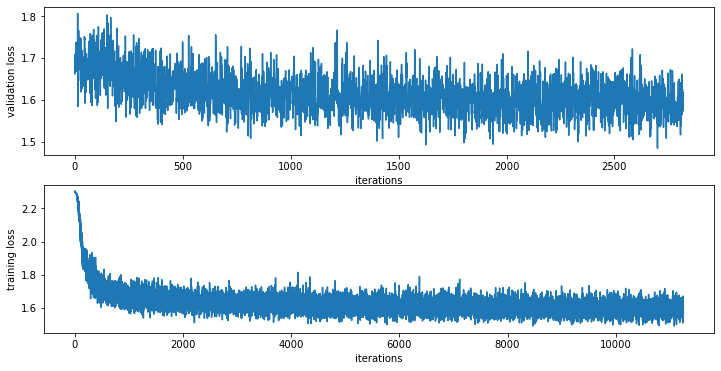

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)

ax1.plot(val_list)
ax1.set_ylabel("validation loss")
ax1.set_xlabel("iterations")
ax2.plot(loss_list)
ax2.set_ylabel("training loss")
ax2.set_xlabel("iterations");